<a href="https://colab.research.google.com/github/teoalcdor/tfg_teoalcdor/blob/main/od_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza del Conjunto de Datos de Detección de Objetos

Vamos a preparar el dataset de detección de objetos para entrenar nuestros modelos. En este notebook nos vamos a asegurar de que las anotaciones, que según los autores del paper en el que se publica el dataset, están en formato Darknet, no contienen errores de formateo. También vamos a comprobar que toda anotación pertenece a una única imagen y que toda imagen tiene una única anotación.

## Librerías

Comenzamos importando las librerías necesarias:

In [ ]:
import albumentations as A
import cv2
from matplotlib.colors import to_rgb
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Funciones Auxiliares y Constantes Globales

Definimos unas variables globales con el número de clases, la ruta al dataset, los posibles errores que vamos a comprobar y las diferentes extensiones de las imágenes que admitiremos:

In [ ]:
LABELS = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

CLASS_DICT = {
    0: "Tank (TANK)",
    1: "Infantry fighting vehicle (IFV)",
    2: "Armored personnel carrier (APC)",
    3: "Engineering vehicle (EV)",
    4: "Assault helicopter (AH)",
    5: "Transport helicopter (TH)",
    6: "Assault airplane (AAP)",
    7: "Transport airplane (TA)",
    8: "Anti-aircraft vehicle (AA)",
    9: "Towed artillery (TART)",
    10: "Self-propelled artillery (SPART)",
    11: "Human"
}
CLASSES = [CLASS_DICT[i] for i in range(11)]

COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'pink', 'brown', 'grey', 'darkgreen']

PATH = "/content/object_detection_dataset_yolo"
PATH_AUGMENTED = "/content/object_detection_dataset_yolo_augmented"
PATH_HUMAN_AUGMENTED = "/content/human_dataset_augmented"
VAL_IMAGE_PATH = "/content/object_detection_dataset_yolo/images/val/"
VAL_ANNOTATION_PATH = "/content/object_detection_dataset_yolo/labels/val/"
HUMAN_IMAGE_PATH = "/content/human_dataset/images/"
HUMAN_ANNOTATION_PATH = "/content/human_dataset/labels/"

POSSIBLE_ERRORS = ["Too many attributes", "Not valid class",
                   "Value out of range", "Incorrect width/height",
                   "Unknown error"]

IMAGE_EXTENSIONS = {".jpg",".png"}

Definimos las funciones que vamos a utilizar para limpiar el dataset:

In [ ]:
def find_image(folder_path, filename):
    """
    Encuentra una imagen (nombre + extension) dado su nombre sin extension.
    """

    base_name = filename[:-4]
    for extension in IMAGE_EXTENSIONS:
        image_path = os.path.join(folder_path, f"{base_name}{extension}")
        if os.path.exists(image_path):
            return f"{base_name}{extension}"

    return base_name


def is_valid(line, image=None):
    """
    Comprueba si una linea de una anotacion es valida.
    """

    # Vemos si podemos leer la linea, si no, tenemos un error desconocido
    try:

        # Dividimos la linea en sus componenetes
        parts = line.strip().split()

        # Comprobamos que tiene 5 componentes
        if len(parts) != 5:
            return False, POSSIBLE_ERRORS[0]

        # Extraemos la clase
        object_class = int(parts[0])

        # Comprobamos que este entre el numero de clases permitido
        if object_class not in LABELS:
            return False, POSSIBLE_ERRORS[1]

        # Comprobamos que los valores esten normalizados
        values = list(map(float, parts[1:5]))
        if not all(0 <= value <= 1 for value in values):
            return False, POSSIBLE_ERRORS[2]

        # Comprobamos que las coordenadas de la caja sean coherentes
        if image is not None:
            h, w, _ = image.shape
            x0, y0 = w * float(parts[1]), h * float(parts[2])
            bbox_w, bbox_h = w * float(parts[3]), h * float(parts[4])
            xmin = x0 - bbox_w * 0.5
            ymin = y0 - bbox_h * 0.5
            xmax = x0 + bbox_w * 0.5
            ymax = y0 + bbox_h * 0.5

            if (xmin >= xmax) or (ymin >= ymax):
                return False, POSSIBLE_ERRORS[3]

        # Si no hemos detectado ningun error, la anotacion es valida
        return True, "Valid annotation"

    except:
        return False, POSSIBLE_ERRORS[4]


def check_annotations(annotations_path, images_path):
    """
    Verifica que las anotaciones de una ruta sean válidas y devuelve un
    diccionario con las anotaciones no válidas y algunos de sus problemas. Este
    diccionario se puede convertir fácilmente en un DataFrame de pandas.
    """

    # Imprimimos de que directorio sacamos los pares
    print(f"Folder: {annotations_path}")

    # Inicializamos el diccionario con los errores
    corrupt_annotations = {
        "filename": [],
        POSSIBLE_ERRORS[0]: [],
        POSSIBLE_ERRORS[1]: [],
        POSSIBLE_ERRORS[2]: [],
        POSSIBLE_ERRORS[3]: [],
        POSSIBLE_ERRORS[4]: []
    }

    # Verificamos la integridad de cada anotacion
    n_annotations = len(os.listdir(annotations_path))

    for annotation_file in tqdm(os.listdir(annotations_path),
                                total=n_annotations,
                                desc="Validating annotations"):

        # Leemos la anotaion y su su imagen
        file_path = os.path.join(annotations_path, annotation_file)
        image = find_image(images_path, annotation_file)
        image = cv2.imread(os.path.join(images_path, image))

        with open(file_path, "r") as f:

            # Leemos las lineas de la anotacion
            lines = f.readlines()
            is_valid_annotation = True
            messages = set()

            # Si la cada linea es valida, y, si no es valida, la registramos
            for i, line in enumerate(lines):
                is_valid_line, message = is_valid(line)
                if not is_valid_line:
                    messages.add(message)
                    is_valid_annotation = False

            # Si la anotacion no es valida por no ser una de sus lineas validas,
            # la registramos, junto con algunos de sus errores
            if not is_valid_annotation:
                corrupt_annotations["filename"].append(annotation_file)
                for error in POSSIBLE_ERRORS:
                    if error in messages:
                        corrupt_annotations[error].append(True)
                    else :
                        corrupt_annotations[error].append(False)
        f.close()

    print()
    print(f" - Number of corrupt annotations: {len(corrupt_annotations['filename'])} of {n_annotations}")
    print(f" - {POSSIBLE_ERRORS[0]}: {sum(corrupt_annotations[POSSIBLE_ERRORS[0]])}")
    print(f" - {POSSIBLE_ERRORS[1]}: {sum(corrupt_annotations[POSSIBLE_ERRORS[1]])}")
    print(f" - {POSSIBLE_ERRORS[2]}: {sum(corrupt_annotations[POSSIBLE_ERRORS[2]])}")
    print(f" - {POSSIBLE_ERRORS[3]}: {sum(corrupt_annotations[POSSIBLE_ERRORS[3]])}")
    print()

    return corrupt_annotations


def move_images(object_files, path_from, path_to):
    """
    Mueve las imagenes que contengan anotaciones a otra carpeta.
    """

    # Para cada nombre de fichero proveniente de una anotacion, trata de mover
    # la imagen asociada
    for object_file in object_files:

        # Leemos la imagen
        image = find_image(path_from, object_file)

        # Si podemos mover la imagen, la movemos
        try:
            shutil.move(
                os.path.join(path_from, image),
                os.path.join(path_to, image),
                copy_function=shutil.copy2
            )
        except:
            print(f"{image} not moved")


def move_annotations(annotations, path_from, path_to):
    """
    Mueve las anotaciones que contengan imagenes a otra carpeta.
    """

    # Para cada anotacion, si es posible moverla, muevela
    for annotation in annotations:
        try:
            shutil.move(
                os.path.join(path_from, annotation),
                os.path.join(path_to, annotation),
                copy_function=shutil.copy2
            )
        except:
            print(f"{annotation} not moved")


def get_images_with_object_class(n_class,
                                 image_path=VAL_IMAGE_PATH,
                                 annotation_path=VAL_ANNOTATION_PATH):
    """
    Obtiene las imágenes con, al menos, un objeto de la clase n_class.
    """

    # Para cada imagen de la ruta, comprobamos si tiene un objeto de esa clase
    # y, si lo tiene, la añadimos a la lista
    images = set()
    for image in os.listdir(image_path):
        filename = image[:-4]
        with open(os.path.join(annotation_path, filename + ".txt"), "r") as f:
            lines = f.readlines()
            for line in lines:
                if int(line.split(" ")[0]) == n_class:
                    images.add(image)
                    break
        f.close()
    return list(images)


def plot_bbox(image, image_path, annotation_path, class_dict=CLASS_DICT, class_colors=COLORS):
    """
    Dibuja unas detecciones a partir de la informacion de las cajas, y
    etiquetas.
    """

    # Leemos la imagen a partir de la anotacion
    annotation = image[:-4] + ".txt"
    img = cv2.imread(os.path.join(image_path, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    w, h = img.shape[1], img.shape[0]

    with open(os.path.join(annotation_path, annotation), "r") as f:
        lines = f.readlines()
        for line in lines:

            # Transformamos las coordenadas de la caja
            bb = line[:-1].split(" ")[1:]
            bb = [float(i) for i in bb]
            bb_w = bb[2] * w
            bb_h = bb[3] * h
            bb_x0 = bb[0] * w
            bb_y0 = bb[1] * h
            bb[0] = bb_x0 - bb_w / 2
            bb[1] = bb_y0 - bb_h / 2
            bb[2] = bb_x0 + bb_w / 2
            bb[3] = bb_y0 + bb_h / 2

            # La etiqueta de la caja
            object_class = int(line.split(" ")[0])
            label = class_dict[object_class]
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.9
            font_thickness = 2
            text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
            text_width, text_height = text_size

            # Tomamos medidas de la caja para centrar la etiqueta
            x0, y0, x1, y1 = bb
            x12 = (x0 + x1) / 2
            x2 = x12 - text_width / 2
            x3 = x12 + text_width / 2

            x0, y0 = int(x0), int(y0)
            x1, y1 = int(x1), int(y1)
            x2, x3 = int(x2), int(x3)

            # Pintamos caja y etiqueta
            bgr = [255 * i for i in to_rgb(class_colors[object_class])]
            img = cv2.rectangle(img, (x0, y0), (x1, y1), bgr, thickness=4)
            img = cv2.rectangle(img, (x2 - 20, y0), (x3 + 20, y0 - text_height - 20), bgr, -1)
            img = cv2.putText(img, label, (x2, y0 - 10), font, 0.9, (255, 255, 255), 2)

    return img

## Carga de los Datos

Montamos nuestra cuenta de Google Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Descomprimimos el archivo:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

## Verificación de las Extensiones

In [ ]:
image_extensions = set()

train_images = set()
val_images = set()
test_images = set()

n_train_images = 0
n_val_images = 0
n_test_images = 0

# Entrenamiento
for image in os.listdir("/content/object_detection_dataset_yolo/images/train/"):
    image_name, image_extension = image.split(".")
    train_images.add(image_name)
    image_extensions.add(image_extension)
    n_train_images += 1

# Validacion
for image in os.listdir("/content/object_detection_dataset_yolo/images/val/"):
    image_name, image_extension = image.split(".")
    val_images.add(image_name)
    image_extensions.add(image_extension)
    n_val_images += 1

# Test
for image in os.listdir("/content/object_detection_dataset_yolo/images/test/"):
    image_name, image_extension = image.split(".")
    test_images.add(image_name)
    image_extensions.add(image_extension)
    n_test_images += 1

print(image_extensions)

{'jpg', 'png'}


Vemos que solo hay dos tipos de extensiones, que son las que se dicen en la descripción de los datos.

In [ ]:
annotation_extensions = set()

train_annotations = set()
val_annotations = set()
test_annotations = set()

n_train_annotations = 0
n_val_annotations = 0
n_test_annotations = 0

# Entrenamiento
for annotation in os.listdir("/content/object_detection_dataset_yolo/labels/train/"):
    annotation_name, annotation_extension = annotation.split(".")
    train_annotations.add(annotation_name)
    annotation_extensions.add(annotation_extension)
    n_train_annotations += 1

# Validacion
for annotation in os.listdir("/content/object_detection_dataset_yolo/labels/val/"):
    annotation_name, annotation_extension = annotation.split(".")
    val_annotations.add(annotation_name)
    annotation_extensions.add(annotation_extension)
    n_val_annotations += 1

# Test
for annotation in os.listdir("/content/object_detection_dataset_yolo/labels/test/"):
    annotation_name, annotation_extension = annotation.split(".")
    test_annotations.add(annotation_name)
    annotation_extensions.add(annotation_extension)
    n_test_annotations += 1

print(annotation_extensions)

{'txt'}


También vemos que todas las anotaciones están en formato TXT

## Imágenes y Anotaciones en Distintos Ficheros

In [ ]:
print(train_images.intersection(val_images))
print(train_images.intersection(test_images))
print(val_images.intersection(test_images))

set()
set()
set()


In [ ]:
print(train_annotations.intersection(val_annotations))
print(train_annotations.intersection(test_annotations))
print(val_annotations.intersection(test_annotations))

set()
set()
set()


No hay imágenes ni anotaciones en que estén en dos conjuntos a la vez. La partición en datos de entrenamiento, test y validación es, en efecto, una partición.

## Correspondencia entre Anotaciones e Imágenes

In [ ]:
print((train_images == train_annotations) & (train_images == train_annotations))
print((val_images == val_annotations) & (n_val_images == n_val_annotations))
print((test_images == test_annotations) & (n_test_images == n_test_annotations))


True
True
True


Por tanto, para cada imagen hay una única anotación y para cada anotación hay una única imagen.

## Anotaciones Corruptas

Comprobamos que todas las anotaciones tengan 5 atributos: la clase, las dos coordenadas del centro de la caja y las dos dimensiones de la caja. También comprobamos que las clases estén dentro de las que consideramos válidas, que los últimos atributos estén normalizados entre 0 y 1 y que la caja no se salga de la imagen.

In [ ]:
corrupt_annotations_train = pd.DataFrame(check_annotations(os.path.join(PATH, "labels/train/"),
                                                           os.path.join(PATH, "images/train/")))
corrupt_annotations_val = pd.DataFrame(check_annotations(os.path.join(PATH, "labels/val/"),
                                                         os.path.join(PATH, "images/val/")))
corrupt_annotations_test = pd.DataFrame(check_annotations(os.path.join(PATH, "labels/test/"),
                                                          os.path.join(PATH, "images/test/")))

Folder: /content/object_detection_dataset_yolo/labels/train/


Validating annotations: 100%|██████████| 11768/11768 [01:48<00:00, 108.03it/s]



 - Number of corrupt annotations: 418 of 11768
 - Too many attributes: 0
 - Not valid class: 0
 - Value out of range: 418
 - Incorrect width/height: 0

Folder: /content/object_detection_dataset_yolo/labels/val/


Validating annotations: 100%|██████████| 1680/1680 [00:13<00:00, 120.67it/s]



 - Number of corrupt annotations: 53 of 1680
 - Too many attributes: 0
 - Not valid class: 0
 - Value out of range: 53
 - Incorrect width/height: 0

Folder: /content/object_detection_dataset_yolo/labels/test/


Validating annotations: 100%|██████████| 3361/3361 [00:33<00:00, 100.62it/s]


 - Number of corrupt annotations: 127 of 3361
 - Too many attributes: 0
 - Not valid class: 0
 - Value out of range: 127
 - Incorrect width/height: 0



## Augmentations

Vamos a aplicar difuminado por movimiento a todas las imágenes y ruido Gaussiano a algunas. Tras ello, les aplicamos compresión de tipo jpeg:

In [ ]:
TRANSFORM = A.Compose([
    A.MotionBlur(blur_limit=(13, 17), p=1),
    A.GaussNoise(mean_range=(-0.1, 0.1), std_range=(0.2, 0.2), p=0.25),
    A.ImageCompression(quality_range=(25, 50), compression_type='jpeg', p=1),
], seed=123)

Una prueba del resultado sería:

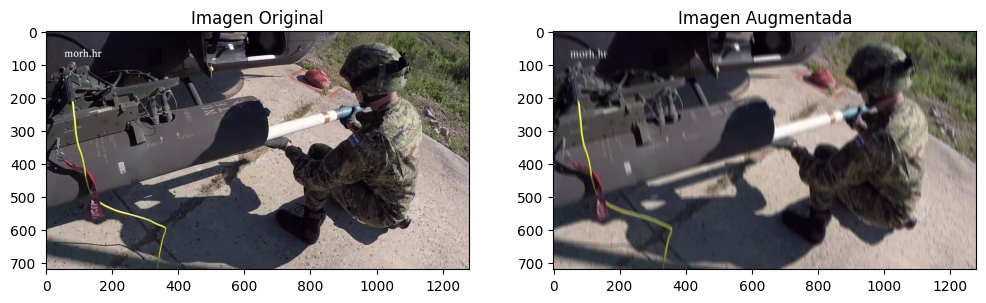

In [ ]:
img = cv2.imread("/content/object_detection_dataset_yolo/images/train/2a59979f-7349-464c-8d76-9653c25ae355.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = TRANSFORM(image=img)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagen Original")

plt.subplot(1, 2, 2)
plt.imshow(image["image"])
plt.title("Imagen Augmentada")

plt.show()

A partir del dataset original creamos el dataset con las augmentations:

In [ ]:
src_folder = '/content/object_detection_dataset_yolo/'
dst_folder = '/content/object_detection_dataset_yolo_augmented/'
shutil.copytree(src_folder, dst_folder)

'/content/object_detection_dataset_yolo_augmented/'

In [ ]:
images_path = "/content/object_detection_dataset_yolo/images/train/"
annotations_path = "/content/object_detection_dataset_yolo/labels/train/"
list_destination_images = os.listdir(images_path)
n_images = len(list_destination_images)

for image in tqdm(list_destination_images, total=n_images):

    # Leemos la imagen
    name = image[:-4]
    extension = image[-4:]
    image_path = os.path.join("/content/object_detection_dataset_yolo_augmented/images/train/", image)
    annotation_path = os.path.join("/content/object_detection_dataset_yolo_augmented/labels/train/", name + ".txt")
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Transformamos la imagen
    transformed_image = TRANSFORM(image=img)
    transformed_image = transformed_image["image"]
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)

    # Nombramos la imagen transformada
    destination_name = name + "_augmented"

    while destination_name + extension in list_destination_images:
        destination_name += "_augmented"

    # Colocamos la imagen transformada y su anotacion en el dataset con augmentations
    cv2.imwrite(f"/content/object_detection_dataset_yolo_augmented/images/train/{destination_name}{extension}", transformed_image)
    src_file = annotation_path
    dst_file = f"/content/object_detection_dataset_yolo_augmented/labels/train/{destination_name}.txt"
    shutil.copy(src_file, dst_file)


100%|██████████| 11768/11768 [16:43<00:00, 11.72it/s]


Comprimimos el dataset con las augmentations y lo guardamos en Drive:

In [ ]:
shutil.make_archive(
    "/content/object_detection_dataset_yolo_augmented",
    "zip",
    "/content",
    "object_detection_dataset_yolo_augmented"
)

'/content/object_detection_dataset_yolo_augmented.zip'

In [ ]:
shutil.copy(
    "/content/object_detection_dataset_yolo_augmented.zip",
    "/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo_augmented.zip"
)

'/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo_augmented.zip'

Vamos a guardar las imagenes corruptas de este dataset para luego. Estas serán las imágenes corruptas del dataset original sumadas a las augmentations de estas:

In [ ]:
corrupt_annotations_train_augmented = pd.DataFrame(check_annotations(os.path.join(PATH_AUGMENTED, "labels/train/"),
                                                                     os.path.join(PATH_AUGMENTED, "images/train/")))

Folder: /content/object_detection_dataset_yolo_augmented/labels/train/


Validating annotations: 100%|██████████| 23536/23536 [03:45<00:00, 104.37it/s]


 - Number of corrupt annotations: 836 of 23536
 - Too many attributes: 0
 - Not valid class: 0
 - Value out of range: 836
 - Incorrect width/height: 0



## Imágenes de Humanos

Para hacer nuestro modelo más robusto ante falsos positivos con personas, añadimos imágenes de humanos con sus correspondientes anotaciones al dataset. Primero creamos el dataset con imágenes de humanos, le hacemos data augmentation como al dataset original y lo añadimos al dataset con data augmentation.

Vamos a utilizar dos datasets distintos. Los descomprimimos:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/human_dataset_1.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/human_dataset_2.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Creamos la carpeta para el datset con fotos humanas. Las imágenes humanas solo seran utilizadas para el entrenamiento, por lo que no es necesario particionarlas:

In [ ]:
os.makedirs("/content/human_dataset")
os.makedirs("/content/human_dataset/images")
os.makedirs("/content/human_dataset/labels")

Añadimos las imágenes y las anotaciones al dataset:

In [ ]:
for data in os.listdir("/content/NewData/images/training/"):
    name, extension = data.split(".")

    # Si es una anotacion, la movemos con las anotacion, si no, con las imagenes
    if extension == "txt":
        shutil.move(
            os.path.join("/content/NewData/images/training/", data),
            os.path.join("/content/human_dataset/labels/", data),
            copy_function=shutil.copy2
        )
    else:
        shutil.move(
            os.path.join("/content/NewData/images/training/", data),
            os.path.join("/content/human_dataset/images/", data),
            copy_function=shutil.copy2
        )

In [ ]:
# Movemos las imagenes
for image in os.listdir("/content/YOLOV5/YOLOV5/train/images/"):
    shutil.move(
        os.path.join("/content/YOLOV5/YOLOV5/train/images/", image),
        os.path.join("/content/human_dataset/images/", image),
        copy_function=shutil.copy2
    )
for image in os.listdir("/content/YOLOV5/YOLOV5/valid/images/"):
    shutil.move(
        os.path.join("/content/YOLOV5/YOLOV5/valid/images/", image),
        os.path.join("/content/human_dataset/images/", image),
        copy_function=shutil.copy2
    )
for image in os.listdir("/content/YOLOV5/YOLOV5/test/images/"):
    shutil.move(
        os.path.join("/content/YOLOV5/YOLOV5/test/images/", image),
        os.path.join("/content/human_dataset/images/", image),
        copy_function=shutil.copy2
    )

# Movemos las anotaciones
for annotation in os.listdir("/content/YOLOV5/YOLOV5/train/labels/"):
    shutil.move(
        os.path.join("/content/YOLOV5/YOLOV5/train/labels/", annotation),
        os.path.join("/content/human_dataset/labels/", annotation),
        copy_function=shutil.copy2
    )
for annotation in os.listdir("/content/YOLOV5/YOLOV5/valid/labels/"):
    shutil.move(
        os.path.join("/content/YOLOV5/YOLOV5/valid/labels/", annotation),
        os.path.join("/content/human_dataset/labels/", annotation),
        copy_function=shutil.copy2
    )
for annotation in os.listdir("/content/YOLOV5/YOLOV5/test/labels/"):
    shutil.move(
        os.path.join("/content/YOLOV5/YOLOV5/test/labels/", annotation),
        os.path.join("/content/human_dataset/labels/", annotation),
        copy_function=shutil.copy2
    )

Vemos cuantas imagenes tenemos y su extension:

In [ ]:
human_images_extensions = set()
human_images = set()
n_human_images = 0

for image in os.listdir("/content/human_dataset/images/"):
    image_name, image_extension = image[:-4], image[-4:]
    human_images.add(image_name)
    human_images_extensions.add(image_extension)
    n_human_images += 1

print(human_images_extensions, n_human_images)

{'.jpg'} 644


Vemos cuantas anotaciones tenemos y su extension:

In [ ]:
human_annotations_extensions = set()
human_annotations = set()
human_classes = set()
n_human_annotations = 0

for annotation in os.listdir("/content/human_dataset/labels/"):
    annotation_name, annotation_extension = annotation[:-4], annotation[-4:]
    human_annotations.add(annotation_name)
    human_annotations_extensions.add(annotation_extension)
    with open(os.path.join("/content/human_dataset/labels/", annotation), "r") as f:
        for line in f.readlines():
            human_classes.add(line[0])
    f.close()
    n_human_annotations += 1

print(human_annotations_extensions, n_human_annotations, human_classes)

{'.txt'} 644 {'0'}


Vemos si el conjunto de imagenes se corresponde con el de anotaciones:

In [ ]:
human_images == human_annotations

True

Los conjuntos son iguales. Como además tenemos el mismo número de anotaciones que de imágenes, la correspondencia será perfecta.

Vemos si hay anotaciones_corruptas:

In [ ]:
corrupt_annotations_human = pd.DataFrame(check_annotations("/content/human_dataset/labels/",
                                                           "/content/human_dataset/images/"))

Folder: /content/human_dataset/labels/


Validating annotations: 100%|██████████| 644/644 [00:04<00:00, 160.28it/s]


 - Number of corrupt annotations: 1 of 644
 - Too many attributes: 0
 - Not valid class: 0
 - Value out of range: 1
 - Incorrect width/height: 0



Solo hay una:

In [ ]:
corrupt_human_annotation = corrupt_annotations_human["filename"][0]
corrupt_human_image = corrupt_human_annotation[:-4] + ".jpg"
corrupt_human_image, corrupt_human_annotation

('664c4905c7cc7eea.jpg', '664c4905c7cc7eea.txt')

Como solo es una, la eliminamos:

In [ ]:
os.remove(os.path.join("/content/human_dataset/labels/", corrupt_human_annotation))
os.remove(os.path.join("/content/human_dataset/images/", corrupt_human_image))

Vamos a cambiar la etiqueta de las anotaciones para que sea 11 en vez de 0:

In [ ]:
for annotation in os.listdir("/content/human_dataset/labels/"):
    newlines = []

    # Leemos la anotacion
    with open(os.path.join("/content/human_dataset/labels/", annotation), "r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            line[0] =  "11"
            line = " ".join(line) + "\n"
            newlines.append(line)
    f.close()

    # Sobreescribimos la anotacion
    with open(os.path.join("/content/human_dataset/labels/", annotation), "w") as f:
        f.writelines(newlines)
    f.close()

Guardamos el conjunto de datos de humanos en Drive:

In [ ]:
shutil.make_archive(
    "/content/human_dataset",
    "zip",
    "/content",
    "human_dataset"
)

'/content/human_dataset.zip'

In [ ]:
shutil.copy(
    "/content/human_dataset.zip",
    "/content/drive/MyDrive/tfg/datasets/human_dataset.zip"
)

'/content/drive/MyDrive/tfg/datasets/human_dataset.zip'

Vamos a hacer augmentations al conjunto de datos de humanos a partir del original:

In [ ]:
src_folder = '/content/human_dataset/'
dst_folder = '/content/human_dataset_augmented/'
shutil.copytree(src_folder, dst_folder)

'/content/human_dataset_augmented/'

Hacemos data augmentation:

In [ ]:
images_path = "/content/human_dataset/images"
n_images = len(os.listdir(images_path))
list_destination_images = os.listdir(images_path)

for image in tqdm(list_destination_images, total=n_images):

    # Leemos la imagen
    name = image[:-4]
    extension = image[-4:]
    image_path = os.path.join("/content/human_dataset_augmented/images/", image)
    annotation_path = os.path.join("/content/human_dataset_augmented/labels/", name + ".txt")
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Transformamos la imagen
    transformed_image = TRANSFORM(image=img)
    transformed_image = transformed_image["image"]
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)

    # Nombramos la imagen transformada
    destination_name = name + "_augmented"

    while destination_name + extension in list_destination_images:
        destination_name += "_augmented"

    # Colocamos la imagen transformada en el dataset con augmentations
    _ = cv2.imwrite(f"/content/human_dataset_augmented/images/{destination_name}{extension}", transformed_image)
    src_file = annotation_path
    dst_file = f"/content/human_dataset_augmented/labels/{destination_name}.txt"
    shutil.copy(src_file, dst_file)

100%|██████████| 643/643 [00:33<00:00, 19.11it/s]


Guardamos el dataset de humanos con data augmentation en Drive:

In [ ]:
shutil.make_archive(
    "/content/human_dataset_augmented",
    "zip",
    "/content",
    "human_dataset_augmented"
)

'/content/human_dataset_augmented.zip'

In [ ]:
shutil.copy(
    "/content/human_dataset_augmented.zip",
    "/content/drive/MyDrive/tfg/datasets/human_dataset_augmented.zip"
)

'/content/drive/MyDrive/tfg/datasets/human_dataset_augmented.zip'

Añadimos los datos de humanos a una copia del dataset con augmentations:

In [ ]:
shutil.copytree(
    "/content/object_detection_dataset_yolo_augmented",
    "/content/object_detection_dataset_yolo_augmented_humans"
)

'/content/object_detection_dataset_yolo_augmented_humans'

In [ ]:
images_path = os.path.join(PATH_HUMAN_AUGMENTED, "images")
annotations_path = os.path.join(PATH_HUMAN_AUGMENTED, "labels")
destination_images_path = os.path.join(PATH_AUGMENTED + "_humans", "images/train")
destination_annotations_path = os.path.join(PATH_AUGMENTED + "_humans", "labels/train")
list_destination_annotations = os.listdir(destination_annotations_path)

n_images = len(os.listdir(images_path))
for image in tqdm(os.listdir(images_path), total=n_images):

    # Extraemos la anotacion de la imagen
    name = image[:-4]
    extension = image[-4:]
    image_path = os.path.join("/content/human_dataset_augmented/images/", image)
    annotation = name + ".txt"
    annotation_path = os.path.join("/content/human_dataset_augmented/labels/", annotation)
    destination_annotation = annotation
    destination_image = image

    # Renombramos si fuera necesario para colocarlas en el dataset conjunto
    i = 1
    while destination_annotation in list_destination_annotations:
        destination_annotation = name + "_human" * i + ".txt"
        destination_image = name + "_human" * i + extension
        i += 1

    # Copiamos la imagen y su anotacion al dataset conjunto
    destination_image_path = os.path.join(destination_images_path, destination_image)
    destination_annotation_path = os.path.join(destination_annotations_path, destination_annotation)

    shutil.copy(image_path, destination_image_path)
    shutil.copy(annotation_path, destination_annotation_path)

100%|██████████| 1286/1286 [00:03<00:00, 381.76it/s]


Guardamos el dataset con augmentations y datos de humanos en Drive:

In [ ]:
shutil.make_archive(
    "/content/object_detection_dataset_yolo_augmented_humans",
    "zip",
    "/content",
    "/content/object_detection_dataset_yolo_augmented_humans"
)

'/content/object_detection_dataset_yolo_augmented_humans.zip'

In [ ]:
shutil.copy(
    "/content/object_detection_dataset_yolo_augmented_humans.zip",
    "/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo_augmented_humans.zip"
)

'/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo_augmented_humans.zip'

## Creación de un Dataset de Imágenes con Anotaciones Corruptas


Crearemos este dataset con el objetivo de volver a etiquetar estás imágenes si fuera necesario.

Creamos la estructura de los ficheros del dataset:


In [ ]:
os.makedirs("/content/corrupt_object_detection_dataset")
os.makedirs("/content/corrupt_object_detection_dataset/images")
os.makedirs("/content/corrupt_object_detection_dataset/images/train")
os.makedirs("/content/corrupt_object_detection_dataset/images/val")
os.makedirs("/content/corrupt_object_detection_dataset/images/test")
os.makedirs("/content/corrupt_object_detection_dataset/labels")
os.makedirs("/content/corrupt_object_detection_dataset/labels/train")
os.makedirs("/content/corrupt_object_detection_dataset/labels/val")
os.makedirs("/content/corrupt_object_detection_dataset/labels/test")

Movemos las imágenes corruptas y sus anotaciones al dataset:

In [ ]:
# Entrenamiento
move_images(
    corrupt_annotations_train["filename"],
    os.path.join(PATH, "images/train/"),
    "/content/corrupt_object_detection_dataset/images/train/"
)
move_annotations(
    corrupt_annotations_train["filename"],
    os.path.join(PATH, "labels/train/"),
    "/content/corrupt_object_detection_dataset/labels/train/"
)

In [ ]:
# Validacion
move_images(
    corrupt_annotations_val["filename"],
    os.path.join(PATH, "images/val/"),
    "/content/corrupt_object_detection_dataset/images/val/"
)
move_annotations(
    corrupt_annotations_val["filename"],
    os.path.join(PATH, "labels/val/"),
    "/content/corrupt_object_detection_dataset/labels/val/"
)

In [ ]:
# Test
move_images(
    corrupt_annotations_test["filename"],
    os.path.join(PATH, "images/test/"),
    "/content/corrupt_object_detection_dataset/images/test/"
)
move_annotations(
    corrupt_annotations_test["filename"],
    os.path.join(PATH, "labels/test/"),
    "/content/corrupt_object_detection_dataset/labels/test/"
)

Comprimimos el dataset y lo guardamos en Drive:

In [ ]:
shutil.make_archive(
    "/content/corrupt_object_detection_dataset",
    "zip",
    "/content",
    "corrupt_object_detection_dataset"
)

'/content/corrupt_object_detection_dataset.zip'

In [ ]:
shutil.copy(
    "/content/corrupt_object_detection_dataset.zip",
    "/content/drive/MyDrive/tfg/datasets/corrupt_object_detection_dataset.zip"
)

'/content/drive/MyDrive/tfg/datasets/corrupt_object_detection_dataset.zip'

## Imagenes con augmentations

Volvemos a hacer lo mismo pero para las imagenes corruptas con augmentations:

In [ ]:
os.makedirs("/content/corrupt_object_detection_dataset_augmented")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/images")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/images/train")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/images/val")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/images/test")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/labels")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/labels/train")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/labels/val")
os.makedirs("/content/corrupt_object_detection_dataset_augmented/labels/test")

In [ ]:
# Entrenamiento
move_images(
    corrupt_annotations_train_augmented["filename"],
    os.path.join(PATH_AUGMENTED, "images/train/"),
    "/content/corrupt_object_detection_dataset_augmented/images/train/"
)
move_annotations(
    corrupt_annotations_train_augmented["filename"],
    os.path.join(PATH_AUGMENTED, "labels/train/"),
    "/content/corrupt_object_detection_dataset_augmented/labels/train/"
)

In [ ]:
# Validacion
move_images(
    corrupt_annotations_val["filename"],
    os.path.join(PATH_AUGMENTED, "images/val/"),
    "/content/corrupt_object_detection_dataset_augmented/images/val/"
)
move_annotations(
    corrupt_annotations_val["filename"],
    os.path.join(PATH_AUGMENTED, "labels/val/"),
    "/content/corrupt_object_detection_dataset_augmented/labels/val/"
)

In [ ]:
# Test
move_images(
    corrupt_annotations_test["filename"],
    os.path.join(PATH_AUGMENTED, "images/test/"),
    "/content/corrupt_object_detection_dataset_augmented/images/test/"
)
move_annotations(
    corrupt_annotations_test["filename"],
    os.path.join(PATH_AUGMENTED, "labels/test/"),
    "/content/corrupt_object_detection_dataset_augmented/labels/test/"
)

In [ ]:
shutil.make_archive(
    "/content/corrupt_object_detection_dataset_augmented",
    "zip",
    "/content",
    "corrupt_object_detection_dataset_augmented"
)

'/content/corrupt_object_detection_dataset_augmented.zip'

In [ ]:
shutil.copy(
    "/content/corrupt_object_detection_dataset_augmented.zip",
    "/content/drive/MyDrive/tfg/datasets/corrupt_object_detection_dataset_augmented.zip"
)

'/content/drive/MyDrive/tfg/datasets/corrupt_object_detection_dataset_augmented.zip'

## Análisis Exploratorio de Datos y Estadística Descriptiva

Vamos a ver cómo son los objetos e imágenes de los diferentes conjuntos creados.

### Objetos del Conjunto de Datos Militar con Anotaciones Válidas

Comenzamos haciendo un DataFrame con las características de los objetos de este conjunto de datos:

In [ ]:
# Entrenamiento
train_df = pd.DataFrame({"class":[], "x":[], "y":[], "w":[], "h":[]})
for filename in os.listdir("/content/object_detection_dataset_yolo/labels/train/"):
    with open(os.path.join("/content/object_detection_dataset_yolo/labels/train/", filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            train_df.loc[len(train_df)] = line[:-1].split(" ")
    f.close()
train_df = train_df.astype(float)
train_df['class'] = train_df['class'].astype(int)

# Validacion
val_df = pd.DataFrame({"class":[], "x":[], "y":[], "w":[], "h":[]})
for filename in os.listdir("/content/object_detection_dataset_yolo/labels/val/"):
    with open(os.path.join("/content/object_detection_dataset_yolo/labels/val/", filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            val_df.loc[len(val_df)] = line[:-1].split(" ")
    f.close()
val_df = val_df.astype(float)
val_df['class'] = val_df['class'].astype(int)

# Test
test_df = pd.DataFrame({"class":[], "x":[], "y":[], "w":[], "h":[]})
for filename in os.listdir("/content/object_detection_dataset_yolo/labels/test/"):
    with open(os.path.join("/content/object_detection_dataset_yolo/labels/test/", filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            test_df.loc[len(test_df)] = line[:-1].split(" ")
    f.close()
test_df = test_df.astype(float)
test_df['class'] = test_df['class'].astype(int)

# Remplazamos cada etiqueta por su clase
train_df.replace({"class": CLASS_DICT}, inplace=True)
val_df.replace({"class": CLASS_DICT}, inplace=True)
test_df.replace({"class": CLASS_DICT}, inplace=True)

# Hacemos el recuento de clases
train_count = train_df["class"].value_counts()
val_count = val_df["class"].value_counts()
test_count = test_df["class"].value_counts()

train_count = train_count.reindex(CLASSES, fill_value=0)
val_count = val_count.reindex(CLASSES, fill_value=0)
test_count = test_count.reindex(CLASSES, fill_value=0)

train_count = train_count.reset_index()
val_count = val_count.reset_index()
test_count = test_count.reset_index()

Representamos la distribución entre clases:

<ipython-input-43-b9b0b059a470>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(train_count['class'], rotation=90, fontsize=13)
<ipython-input-43-b9b0b059a470>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(val_count['class'], rotation=90, fontsize=13)
<ipython-input-43-b9b0b059a470>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(test_count['class'], rotation=90, fontsize=13)


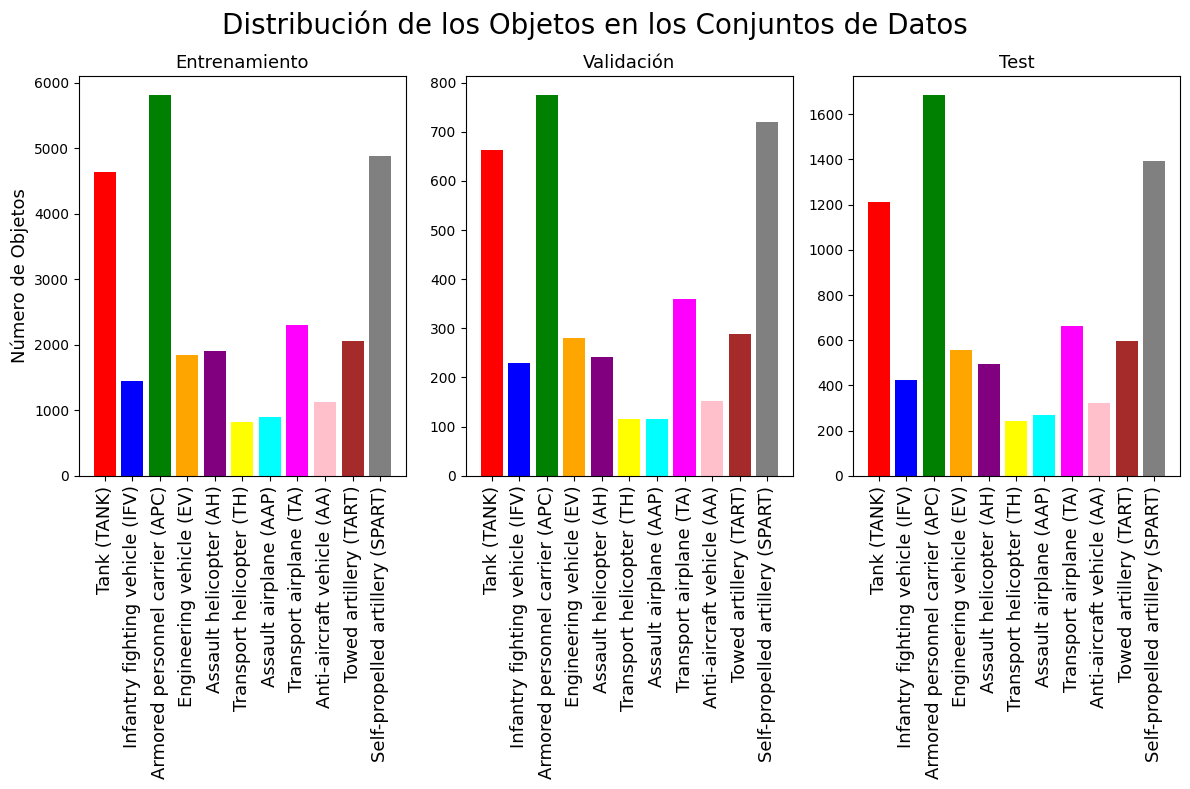

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

# Entrenamiento
axs[0].bar(train_count['class'], train_count['count'], color=COLORS)
axs[0].set_xticklabels(train_count['class'], rotation=90, fontsize=13)
axs[0].set_ylabel('Número de Objetos', fontsize=13)
axs[0].set_title('Entrenamiento', fontsize=13)

# Validacion
axs[1].bar(val_count['class'], val_count['count'], color=COLORS)
axs[1].set_xticklabels(val_count['class'], rotation=90, fontsize=13)
axs[1].set_title('Validación', fontsize=13)

# Test
axs[2].bar(test_count['class'], test_count['count'], color=COLORS)
axs[2].set_xticklabels(test_count['class'], rotation=90, fontsize=13)
axs[2].set_title('Test', fontsize=13)

fig.suptitle('Distribución de los Objetos en los Conjuntos de Datos', fontsize=20)
plt.tight_layout()
plt.show()

Representamos la distribución de los centros:

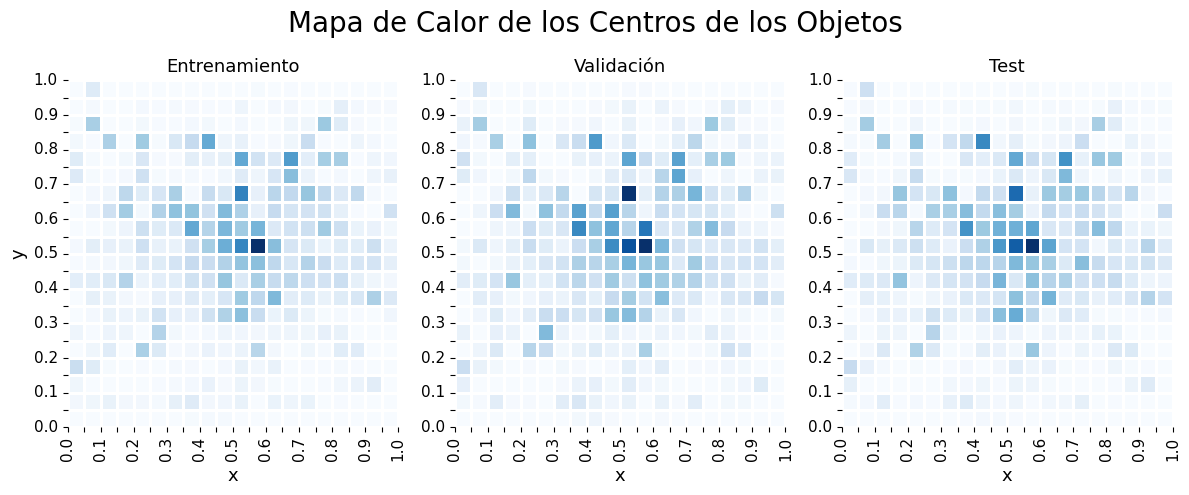

In [ ]:
# Calculamos las bins y las ticks de los ejes
x_min = min(train_df["x"].min(), val_df["x"].min(), test_df["x"].min())
x_max = max(train_df["x"].max(), val_df["x"].max(), test_df["x"].max())
y_min = min(train_df["y"].min(), val_df["y"].min(), test_df["y"].min())
y_max = max(train_df["y"].max(), val_df["y"].max(), test_df["y"].max())
x_min = round(x_min, 1)
x_max = round(x_max, 1)
y_min = round(y_min, 1)
y_max = round(y_max, 1)
bins_x = np.linspace(x_min, x_max + 2) - 0.5
bins_y = np.linspace(y_min, y_max + 2) - 0.5

tick_vals = np.round(np.arange(0, 1.01, 0.05), 2)
tick_vals = tick_vals.astype(str)
tick_vals[1::2] = ""
tick_locs = np.linspace(0, 20, len(tick_vals))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Entrenamiento
heatmap, xedges, yedges = np.histogram2d(
    train_df['y'],
    train_df['x'],
    bins=[20, 20],
    range=[[x_min, x_max], [y_min, y_max]])
sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[0])
axs[0].set_xticks(tick_locs)
axs[0].set_xticklabels(tick_vals, rotation=90, fontsize=11)
axs[0].set_yticks(tick_locs)
axs[0].set_yticklabels(tick_vals, rotation=0, fontsize=11)
axs[0].invert_yaxis()
axs[0].set_xlabel('x', fontsize=13)
axs[0].set_ylabel('y', fontsize=13)
axs[0].set_title('Entrenamiento', fontsize=13)

# Validacion
heatmap, xedges, yedges = np.histogram2d(
    val_df['y'],
    val_df['x'],
    bins=[20, 20],
    range=[[x_min, x_max], [y_min, y_max]])
sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[1])
axs[1].set_xticks(tick_locs)
axs[1].set_xticklabels(tick_vals, rotation=90, fontsize=11)
axs[1].set_yticks(tick_locs)
axs[1].set_yticklabels(tick_vals, rotation=0, fontsize=11)
axs[1].invert_yaxis()
axs[1].set_xlabel('x', fontsize=13)
axs[1].set_title('Validación', fontsize=13)

# Test
heatmap, xedges, yedges = np.histogram2d(
    test_df['y'],
    test_df['x'],
    bins=[20, 20],
    range=[[x_min, x_max], [y_min, y_max]])
sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[2])
axs[2].set_xticks(tick_locs)
axs[2].set_xticklabels(tick_vals, rotation=90, fontsize=11)
axs[2].set_yticks(tick_locs)
axs[2].set_yticklabels(tick_vals, rotation=0, fontsize=11)
axs[2].invert_yaxis()
axs[2].set_xlabel('x', fontsize=13)
axs[2].set_title('Test', fontsize=13)

fig.suptitle('Mapa de Calor de los Centros de los Objetos', fontsize=20)
plt.tight_layout()
plt.show()

Representamos la distribución de las alturas y las anchuras:

<ipython-input-45-fc2367cfd651>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(tick_vals, fontsize=12)
<ipython-input-45-fc2367cfd651>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(tick_vals, fontsize=12)
<ipython-input-45-fc2367cfd651>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(tick_vals, fontsize=12)
<ipython-input-45-fc2367cfd651>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(tick_vals, fontsize=12)
<ipython-input-45-fc2367cfd651>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

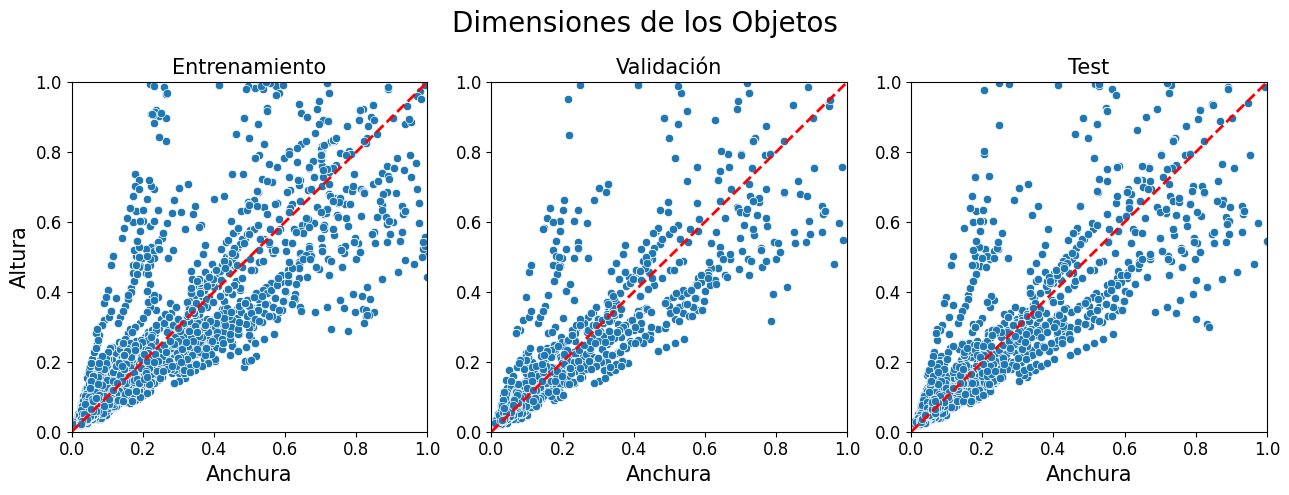

In [ ]:
# Calculamos las bins y las ticks de los ejes
w_min = min(train_df["w"].min(), val_df["w"].min(), test_df["w"].min())
w_max = max(train_df["w"].max(), val_df["w"].max(), test_df["w"].max())
h_min = min(train_df["h"].min(), val_df["h"].min(), test_df["h"].min())
h_max = max(train_df["h"].max(), val_df["h"].max(), test_df["h"].max())
w_min = round(w_min, 1)
w_max = round(w_max, 1)
h_min = round(h_min, 1)
h_max = round(h_max, 1)

tick_vals = np.round(np.arange(0, 1.01, 0.2), 2)
tick_vals = tick_vals.astype(str)

fig, axs = plt.subplots(1, 3, figsize=(13, 5))

# Entrenamiento
sns.scatterplot(x=train_df["w"], y=train_df["h"], ax=axs[0])
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
axs[0].set_xlabel('Anchura', fontsize=15)
axs[0].set_ylabel('Altura', fontsize=15)
axs[0].set_title('Entrenamiento', fontsize=15)
axs[0].set_xticklabels(tick_vals, fontsize=12)
axs[0].set_yticklabels(tick_vals, fontsize=12)

# Validacion
sns.scatterplot(x=val_df["w"], y=val_df["h"], ax=axs[1])
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
axs[1].set_xlabel('Anchura', fontsize=15)
axs[1].set_ylabel('')
axs[1].set_title('Validación', fontsize=15)
axs[1].set_xticklabels(tick_vals, fontsize=12)
axs[1].set_yticklabels(tick_vals, fontsize=12)

# Test
sns.scatterplot(x=test_df["w"], y=test_df["h"], ax=axs[2])
axs[2].set_xlim(0, 1)
axs[2].set_ylim(0, 1)
axs[2].plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
axs[2].set_xlabel('Anchura', fontsize=15)
axs[2].set_ylabel('')
axs[2].set_title('Test', fontsize=15)
axs[2].set_xticklabels(tick_vals, fontsize=12)
axs[2].set_yticklabels(tick_vals, fontsize=12)

fig.suptitle('Dimensiones de los Objetos', fontsize=20)

plt.tight_layout()
plt.show()

### Objetos del Conjunto de Datos Militar con Anotaciones Corruptas

Comenzamos haciendo un DataFrame con las características de los objetos de este conjunto de datos:

In [ ]:
# Entrenamiento
corrupt_train_df = pd.DataFrame({"class":[], "x":[], "y":[], "w":[], "h":[]})
for filename in os.listdir("/content/corrupt_object_detection_dataset/labels/train/"):
    with open(os.path.join("/content/corrupt_object_detection_dataset/labels/train/", filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            corrupt_train_df.loc[len(corrupt_train_df)] = line[:-1].split(" ")
    f.close()
corrupt_train_df = corrupt_train_df.astype(float)
corrupt_train_df['class'] = corrupt_train_df['class'].astype(int)

# Validacion
corrupt_val_df = pd.DataFrame({"class":[], "x":[], "y":[], "w":[], "h":[]})
for filename in os.listdir("/content/corrupt_object_detection_dataset/labels/val/"):
    with open(os.path.join("/content/corrupt_object_detection_dataset/labels/val/", filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            corrupt_val_df.loc[len(corrupt_val_df)] = line[:-1].split(" ")
    f.close()
corrupt_val_df = corrupt_val_df.astype(float)
corrupt_val_df['class'] = corrupt_val_df['class'].astype(int)

# Test
corrupt_test_df = pd.DataFrame({"class":[], "x":[], "y":[], "w":[], "h":[]})
for filename in os.listdir("/content/corrupt_object_detection_dataset/labels/test/"):
    with open(os.path.join("/content/corrupt_object_detection_dataset/labels/test/", filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            corrupt_test_df.loc[len(corrupt_test_df)] = line[:-1].split(" ")
    f.close()
corrupt_test_df = corrupt_test_df.astype(float)
corrupt_test_df['class'] = corrupt_test_df['class'].astype(int)

# Remplazamos cada etiqueta por su clase
corrupt_train_df.replace({"class": CLASS_DICT}, inplace=True)
corrupt_val_df.replace({"class": CLASS_DICT}, inplace=True)
corrupt_test_df.replace({"class": CLASS_DICT}, inplace=True)

# Hacemos el recuento de clases
corrupt_train_count = corrupt_train_df["class"].value_counts()
corrupt_val_count = corrupt_val_df["class"].value_counts()
corrupt_test_count = corrupt_test_df["class"].value_counts()

corrupt_train_count = corrupt_train_count.reindex(CLASSES, fill_value=0)
corrupt_val_count = corrupt_val_count.reindex(CLASSES, fill_value=0)
corrupt_test_count = corrupt_test_count.reindex(CLASSES, fill_value=0)

corrupt_train_count = corrupt_train_count.reset_index()
corrupt_val_count = corrupt_val_count.reset_index()
corrupt_test_count = corrupt_test_count.reset_index()

Representamos la distribución entre clases:

<ipython-input-47-7ea128374922>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(corrupt_train_count['class'], rotation=90, fontsize=13)
<ipython-input-47-7ea128374922>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(corrupt_val_count['class'], rotation=90, fontsize=13)
<ipython-input-47-7ea128374922>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(corrupt_test_count['class'], rotation=90, fontsize=13)


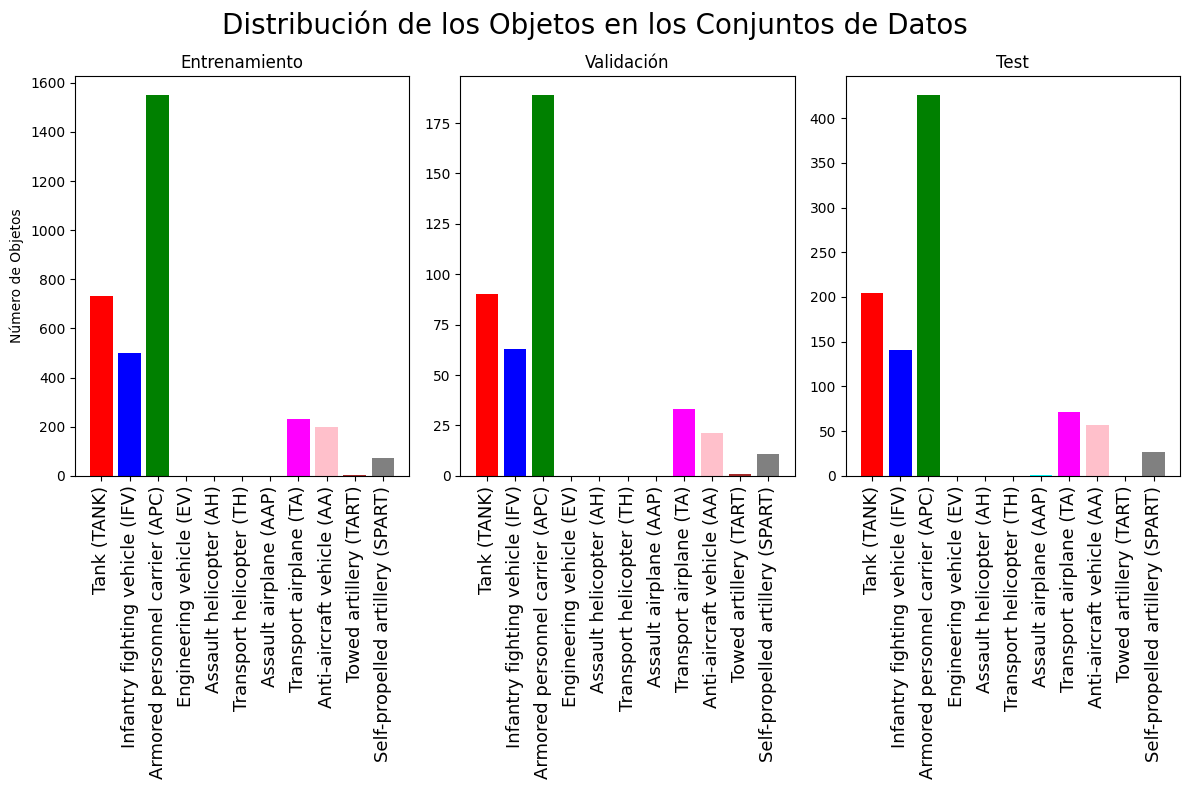

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].bar(corrupt_train_count['class'], corrupt_train_count['count'], color=COLORS)
axs[0].set_xticklabels(corrupt_train_count['class'], rotation=90, fontsize=13)
axs[0].set_ylabel('Número de Objetos')
axs[0].set_title('Entrenamiento')

axs[1].bar(corrupt_val_count['class'], corrupt_val_count['count'], color=COLORS)
axs[1].set_xticklabels(corrupt_val_count['class'], rotation=90, fontsize=13)
axs[1].set_title('Validación')

axs[2].bar(corrupt_test_count['class'], corrupt_test_count['count'], color=COLORS)
axs[2].set_xticklabels(corrupt_test_count['class'], rotation=90, fontsize=13)
axs[2].set_title('Test')

fig.suptitle('Distribución de los Objetos en los Conjuntos de Datos', fontsize=20)
plt.tight_layout()
plt.show()

Representamos la distribución de los centros:

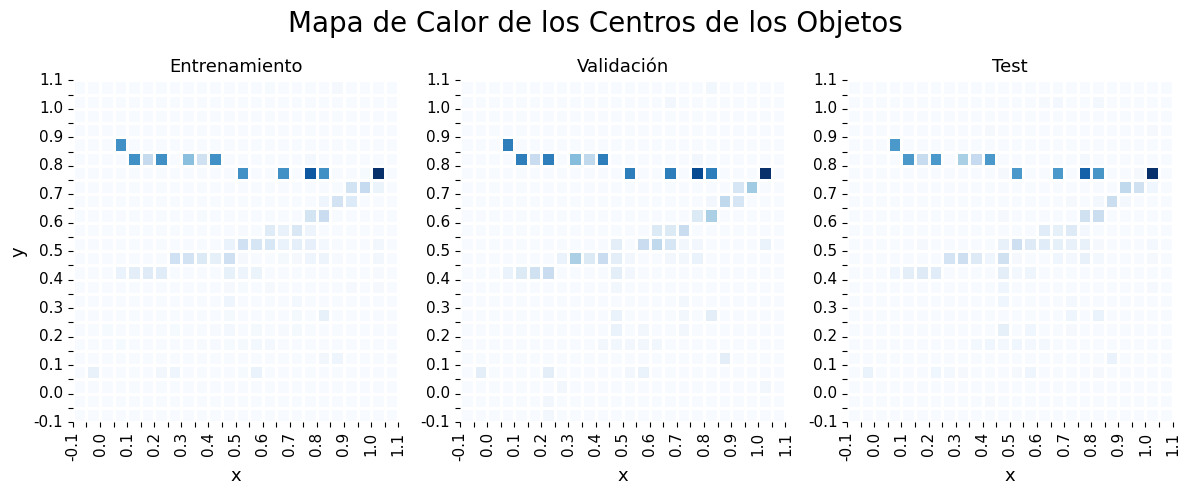

In [ ]:
# Calculamos las bins y las ticks de los ejes
x_min = min(corrupt_train_df["x"].min(), corrupt_val_df["x"].min(), corrupt_test_df["x"].min())
x_max = max(corrupt_train_df["x"].max(), corrupt_val_df["x"].max(), corrupt_test_df["x"].max())
y_min = min(corrupt_train_df["y"].min(), corrupt_val_df["y"].min(), corrupt_test_df["y"].min())
y_max = max(corrupt_train_df["y"].max(), corrupt_val_df["y"].max(), corrupt_test_df["y"].max())
x_min = round(x_min, 1)
x_max = round(x_max, 1)
y_min = round(y_min, 1)
y_max = round(y_max, 1)
bins_x = np.linspace(x_min, x_max + 2) - 0.5
bins_y = np.linspace(y_min, y_max + 2) - 0.5

tick_vals = np.round(np.arange(-0.1, 1.11, 0.05), 2)
tick_vals = tick_vals.astype(str)
tick_vals[1::2] = ""
tick_locs = np.linspace(0, 24, len(tick_vals))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Entrenamiento
heatmap, xedges, yedges = np.histogram2d(
    corrupt_train_df['y'],
    corrupt_train_df['x'],
    bins=[24, 24],
    range=[[x_min, x_max], [y_min, y_max]])
sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[0])
axs[0].set_xticks(tick_locs)
axs[0].set_xticklabels(tick_vals, rotation=90, fontsize=11)
axs[0].set_yticks(tick_locs)
axs[0].set_yticklabels(tick_vals, rotation=0, fontsize=11)
axs[0].invert_yaxis()
axs[0].set_xlabel('x', fontsize=13)
axs[0].set_ylabel('y', fontsize=13)
axs[0].set_title('Entrenamiento', fontsize=13)

# Validacion
heatmap, xedges, yedges = np.histogram2d(
    corrupt_val_df['y'],
    corrupt_val_df['x'],
    bins=[24, 24],
    range=[[x_min, x_max], [y_min, y_max]])
sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[1])
axs[1].set_xticks(tick_locs)
axs[1].set_xticklabels(tick_vals, rotation=90, fontsize=11)
axs[1].set_yticks(tick_locs)
axs[1].set_yticklabels(tick_vals, rotation=0, fontsize=11)
axs[1].invert_yaxis()
axs[1].set_xlabel('x', fontsize=13)
axs[1].set_title('Validación', fontsize=13)

# Test
heatmap, xedges, yedges = np.histogram2d(
    corrupt_test_df['y'],
    corrupt_test_df['x'],
    bins=[24, 24],
    range=[[x_min, x_max], [y_min, y_max]])
sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[2])
axs[2].set_xticks(tick_locs)
axs[2].set_xticklabels(tick_vals, rotation=90, fontsize=11)
axs[2].set_yticks(tick_locs)
axs[2].set_yticklabels(tick_vals, rotation=0, fontsize=11)
axs[2].invert_yaxis()
axs[2].set_xlabel('x', fontsize=13)
axs[2].set_title('Test', fontsize=13)

fig.suptitle('Mapa de Calor de los Centros de los Objetos', fontsize=20)
plt.tight_layout()
plt.show()

Representamos la distribución de las alturas y las anchuras:

<ipython-input-49-efbc75ecda28>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(xtick_vals, fontsize=16)
<ipython-input-49-efbc75ecda28>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(ytick_vals, fontsize=16)
<ipython-input-49-efbc75ecda28>:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(xtick_vals, fontsize=16)
<ipython-input-49-efbc75ecda28>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(ytick_vals, fontsize=16)
<ipython-input-49-efbc75ecda28>:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or us

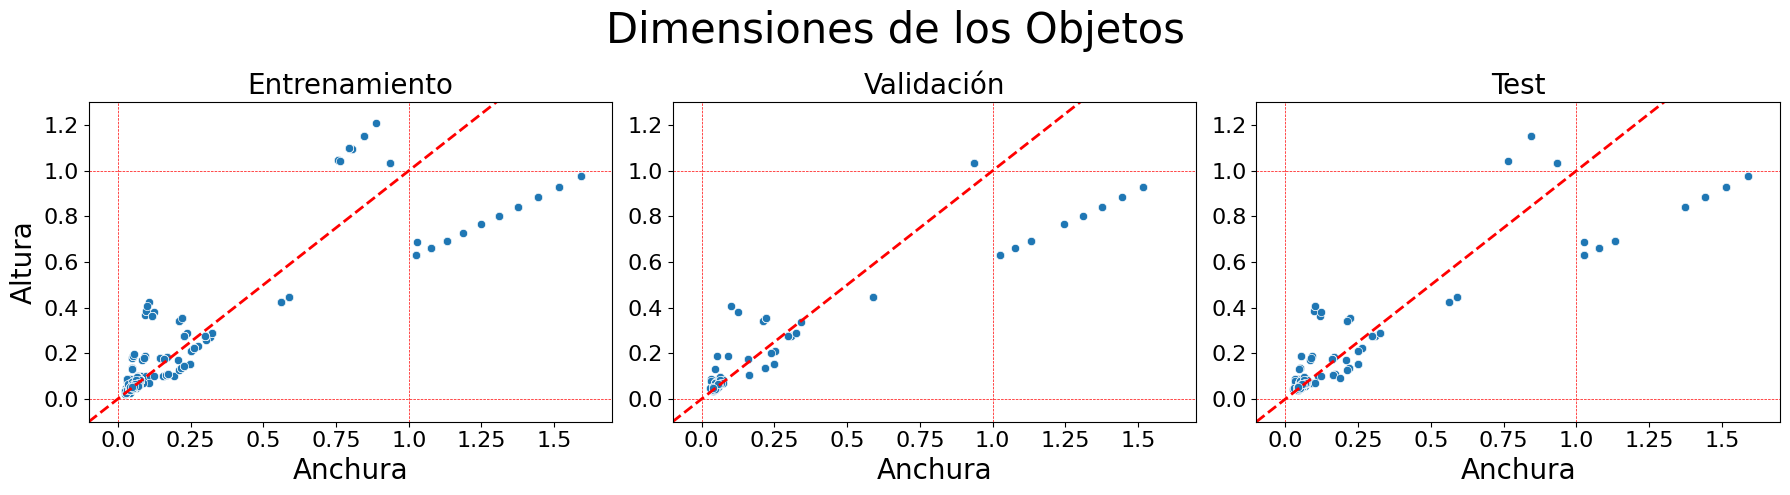

In [ ]:
# Calculamos las bins y las ticks de los ejes
w_min = min(corrupt_train_df["w"].min(), corrupt_val_df["w"].min(), corrupt_test_df["w"].min())
w_max = max(corrupt_train_df["w"].max(), corrupt_val_df["w"].max(), corrupt_test_df["w"].max())
h_min = min(corrupt_train_df["h"].min(), corrupt_val_df["h"].min(), corrupt_test_df["h"].min())
h_max = max(corrupt_train_df["h"].max(), corrupt_val_df["h"].max(), corrupt_test_df["h"].max())
w_min = round(w_min, 1) - 0.1
w_max = round(w_max, 1) + 0.1
h_min = round(h_min, 1) - 0.1
h_max = round(h_max, 1) + 0.1
wh_min = min(w_min, h_min)
wh_max = max(w_max, h_max)

xtick_vals = np.round(np.arange(-0.25, 1.51, 0.25), 2)
xtick_vals = xtick_vals.astype(str)
ytick_vals = np.round(np.arange(-0.2, 1.21, 0.2), 2)
ytick_vals = ytick_vals.astype(str)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Entrenamiento
sns.scatterplot(x=corrupt_train_df["w"], y=corrupt_train_df["h"], ax=axs[0])
axs[0].axhline(y=0, color='r', linestyle='--', linewidth=0.5)
axs[0].axhline(y=1, color='r', linestyle='--', linewidth=0.5)
axs[0].axvline(x=0, color='r', linestyle='--', linewidth=0.5)
axs[0].axvline(x=1, color='r', linestyle='--', linewidth=0.5)
axs[0].plot([wh_min, wh_max], [wh_min, wh_max], color='red', linestyle='--', linewidth=2)
axs[0].set_xlim(w_min, w_max)
axs[0].set_ylim(h_min, h_max)
axs[0].set_xlabel('Anchura', fontsize=20)
axs[0].set_ylabel('Altura', fontsize=20)
axs[0].set_title('Entrenamiento', fontsize=20)
axs[0].set_xticklabels(xtick_vals, fontsize=16)
axs[0].set_yticklabels(ytick_vals, fontsize=16)

# Validacion
sns.scatterplot(x=corrupt_val_df["w"], y=corrupt_val_df["h"], ax=axs[1])
axs[1].axhline(y=0, color='r', linestyle='--', linewidth=0.5)
axs[1].axhline(y=1, color='r', linestyle='--', linewidth=0.5)
axs[1].axvline(x=0, color='r', linestyle='--', linewidth=0.5)
axs[1].axvline(x=1, color='r', linestyle='--', linewidth=0.5)
axs[1].plot([wh_min, wh_max], [wh_min, wh_max], color='red', linestyle='--', linewidth=2)
axs[1].set_xlim(w_min, w_max)
axs[1].set_ylim(h_min, h_max)
axs[1].set_xlabel('Anchura', fontsize=20)
axs[1].set_ylabel('')
axs[1].set_title('Validación', fontsize=20)
axs[1].set_xticklabels(xtick_vals, fontsize=16)
axs[1].set_yticklabels(ytick_vals, fontsize=16)

# Test
sns.scatterplot(x=corrupt_test_df["w"], y=corrupt_test_df["h"], ax=axs[2])
axs[2].axhline(y=0, color='r', linestyle='--', linewidth=0.5)
axs[2].axhline(y=1, color='r', linestyle='--', linewidth=0.5)
axs[2].axvline(x=0, color='r', linestyle='--', linewidth=0.5)
axs[2].axvline(x=1, color='r', linestyle='--', linewidth=0.5)
axs[2].plot([wh_min, wh_max], [wh_min, wh_max], color='red', linestyle='--', linewidth=2)
axs[2].set_xlim(w_min, w_max)
axs[2].set_ylim(h_min, h_max)
axs[2].set_xlabel('Anchura', fontsize=20)
axs[2].set_ylabel('')
axs[2].set_title('Test', fontsize=20)
axs[2].set_xticklabels(xtick_vals, fontsize=16)
axs[2].set_yticklabels(ytick_vals, fontsize=16)

fig.suptitle('Dimensiones de los Objetos', fontsize=30)

plt.tight_layout()
plt.show()

### Objetos del Conjunto de Datos de Humanos

Vamos a explorar las características de los objetos del *dataset* de humanos. Comenzamos haciendo un *dataframe* con ellas:

In [ ]:
human_df = pd.DataFrame({"class":[], "x":[], "y":[], "w":[], "h":[]})
for filename in os.listdir("/content/human_dataset/labels/"):
    with open(os.path.join("/content/human_dataset/labels/", filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            human_df.loc[len(human_df)] = line[:-1].split(" ")
    f.close()
human_df = human_df.astype(float)
human_df['class'] = human_df['class'].astype(int)


Las representamos:

<ipython-input-51-4cc4e58b5991>:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(tick_vals, fontsize=15)
<ipython-input-51-4cc4e58b5991>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(tick_vals, fontsize=15)


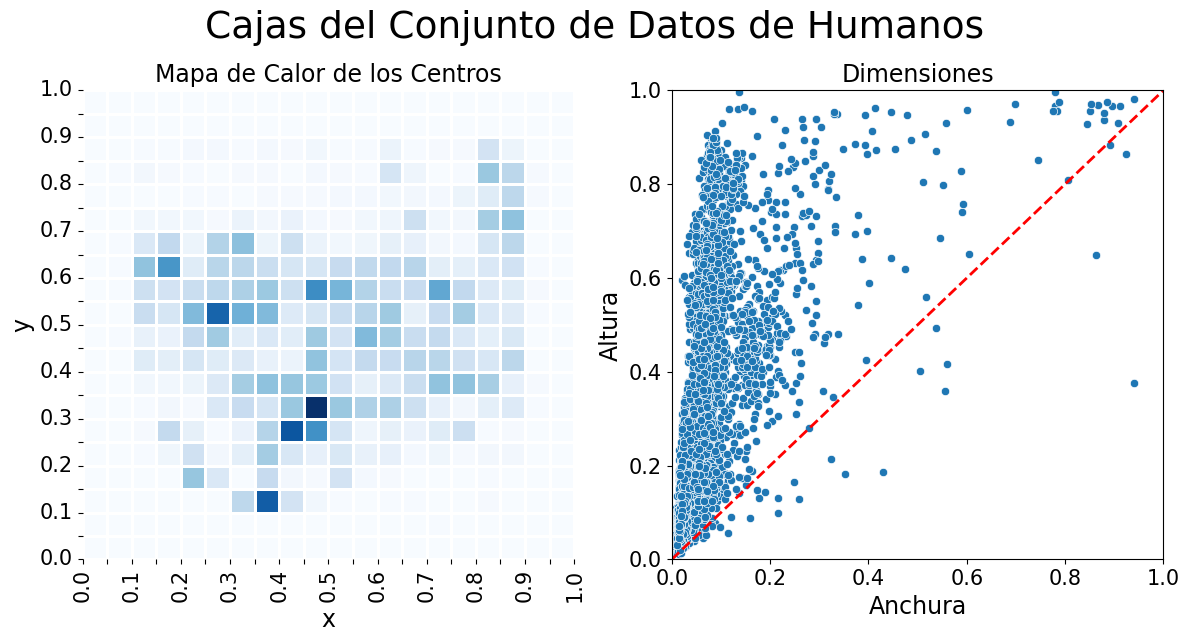

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6.5))

# Mapa de Calor de los Centros

bins_x = np.linspace(0, 1 + 2) - 0.5
bins_y = np.linspace(0, 1 + 2) - 0.5

tick_vals = np.round(np.arange(-0, 1.01, 0.05), 2)
tick_vals = tick_vals.astype(str)
tick_vals[1::2] = ""
tick_locs = np.linspace(0, 20, len(tick_vals))

heatmap, xedges, yedges = np.histogram2d(
    human_df['y'],
    human_df['x'],
    bins=[20, 20],
    range=[[x_min, x_max], [y_min, y_max]])
sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[0])
axs[0].set_xticks(tick_locs)
axs[0].set_xticklabels(tick_vals, rotation=90, fontsize=15)
axs[0].set_yticks(tick_locs)
axs[0].set_yticklabels(tick_vals, rotation=0, fontsize=15)
axs[0].invert_yaxis()
axs[0].set_xlabel('x', fontsize=17)
axs[0].set_ylabel('y', fontsize=17)
axs[0].set_title('Mapa de Calor de los Centros', fontsize=17)

# Dimensiones
tick_vals = np.round(np.arange(-0, 1.01, 0.2), 2)
tick_vals = tick_vals.astype(str)
sns.scatterplot(x=human_df["w"], y=human_df["h"], ax=axs[1])
axs[1].plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Anchura', fontsize=17)
axs[1].set_ylabel('Altura', fontsize=17)
axs[1].set_title('Dimensiones', fontsize=17)
axs[1].set_xticklabels(tick_vals, fontsize=15)
axs[1].set_yticklabels(tick_vals, fontsize=15)

fig.suptitle('Cajas del Conjunto de Datos de Humanos', fontsize=27)
plt.tight_layout()
plt.show()

### Muestras de Imágenes

Una muestra de las imágenes del *dataset* militar:

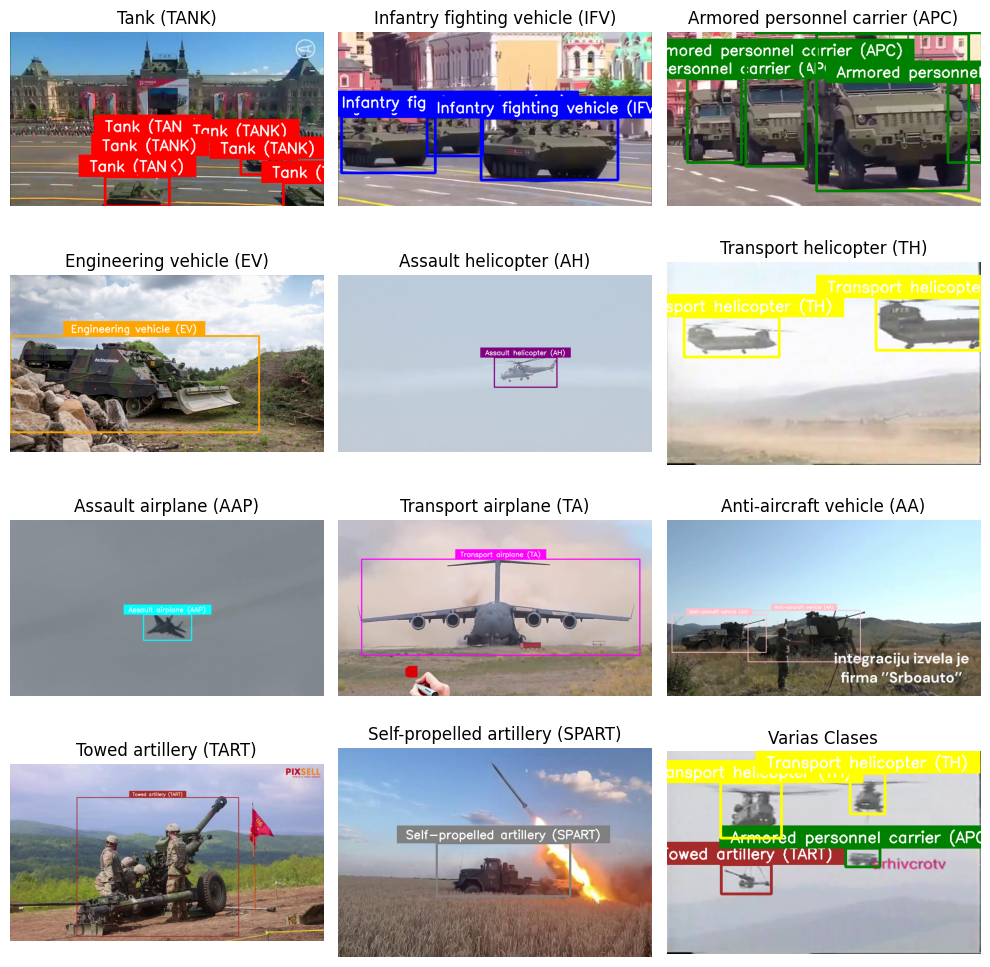

In [ ]:
# Obtenemos las imagenes con las cajas pintadas
img_0 = plot_bbox(get_images_with_object_class(0)[8], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_1 = plot_bbox(get_images_with_object_class(1)[50], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_2 = plot_bbox(get_images_with_object_class(2)[175], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_3 = plot_bbox(get_images_with_object_class(3)[10], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_4 = plot_bbox(get_images_with_object_class(4)[61], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_5 = plot_bbox(get_images_with_object_class(5)[18], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_6 = plot_bbox(get_images_with_object_class(6)[21], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_7 = plot_bbox(get_images_with_object_class(7)[9], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_8 = plot_bbox(get_images_with_object_class(8)[20], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_9 = plot_bbox(get_images_with_object_class(9)[10], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_10 = plot_bbox(get_images_with_object_class(10)[80], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)
img_11 = plot_bbox(get_images_with_object_class(5)[75], VAL_IMAGE_PATH, VAL_ANNOTATION_PATH)

# Las representamos
fig, axs = plt.subplots(4, 3, figsize=(10, 10))

axs[0, 0].imshow(img_0)
axs[0, 0].set_title("Tank (TANK)")
axs[0, 0].axis("off")
axs[0, 1].imshow(img_1)
axs[0, 1].set_title("Infantry fighting vehicle (IFV)")
axs[0, 1].axis("off")
axs[0, 2].imshow(img_2)
axs[0, 2].set_title("Armored personnel carrier (APC)")
axs[0, 2].axis("off")
axs[1, 0].imshow(img_3)
axs[1, 0].set_title("Engineering vehicle (EV)")
axs[1, 0].axis("off")
axs[1, 1].imshow(img_4)
axs[1, 1].set_title("Assault helicopter (AH)")
axs[1, 1].axis("off")
axs[1, 2].imshow(img_5)
axs[1, 2].set_title("Transport helicopter (TH)")
axs[1, 2].axis("off")
axs[2, 0].imshow(img_6)
axs[2, 0].set_title("Assault airplane (AAP)")
axs[2, 0].axis("off")
axs[2, 1].imshow(img_7)
axs[2, 1].set_title("Transport airplane (TA)")
axs[2, 1].axis("off")
axs[2, 2].imshow(img_8)
axs[2, 2].set_title("Anti-aircraft vehicle (AA)")
axs[2, 2].axis("off")
axs[3, 0].imshow(img_9)
axs[3, 0].set_title("Towed artillery (TART)")
axs[3, 0].axis("off")
axs[3, 1].imshow(img_10)
axs[3, 1].set_title("Self-propelled artillery (SPART)")
axs[3, 1].axis("off")
axs[3, 2].imshow(img_11)
axs[3, 2].set_title("Varias Clases")
axs[3, 2].axis("off")

plt.tight_layout()
plt.show()

Una muestra de las imágenes de humanos:

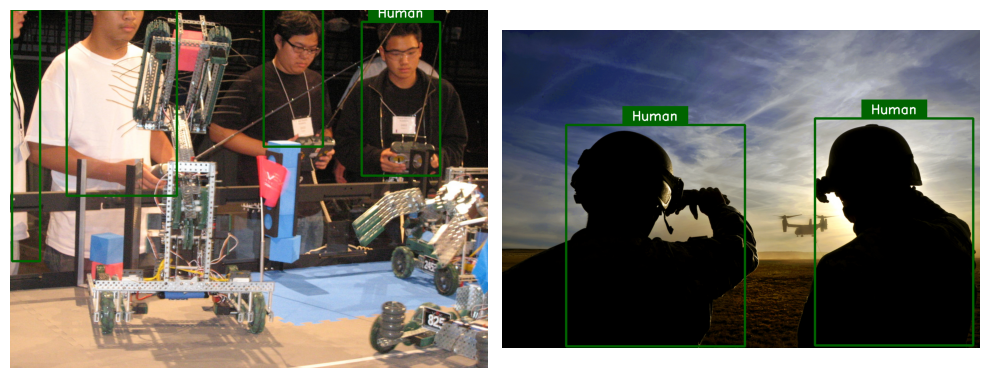

In [ ]:
# Obtenemos las imagenes con las cajas pintadas
img_human_1 = plot_bbox("1a692211f48768a0.jpg", HUMAN_IMAGE_PATH, HUMAN_ANNOTATION_PATH)
img_human_2 = plot_bbox("13491ab45c76831c.jpg", HUMAN_IMAGE_PATH, HUMAN_ANNOTATION_PATH)

# Las representamos
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_human_1)
axs[0].axis("off")
axs[1].imshow(img_human_2)
axs[1].axis("off")

plt.tight_layout()
plt.show()